# Predictive Modelling for House Prices Dataset
This notebook contains the model development for the kaggle competition - [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).   
The data exploration for this analysis is completed in *[a separate notebook](.\1__House_Prices_EDA.ipynb)*.  
Contents
1. Preprocessing   
       1a. The EDA findings are used to inform the preprocessing steps followed.   
           All preprocessing steps utlise the sklearn pipeline format. This allows for quick manipulation   
           and testing of the whole preprocessing stage. 
       1b. Preprocessing refinement - Each step is assessed to ensure it provides a positive impact on predicitve
           perrformance.
       1c. The final preprocessing pipe created.
2. Model Selection 
        2a. Algorithm tests - Asses performance of different model types.
            Gridsearch used to tune hyperparameters.
        2b. Ensemble methods - Check performance of combining different models.
3. Competition Submission

## Imports

In [1]:
# Import Packages
## General
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
import numpy as np
import itertools
from tqdm import tqdm

# Visualisation
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

## Sklean
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

# Random Seed for reproducibilty
seed = 42
np.random.seed = seed

In [2]:
# Import Data
train = pd.read_csv('datasets/train.csv')
y = np.log1p(train.SalePrice) #EDA Finding 1
X = train.drop(['SalePrice', 'Id'], axis=1)

## 1. Preprocessing

### 1a. EDA Findings
Findings taken from *[1__House_Prices_EDA](.\1__House_Prices_EDA.ipynb)*.  to be considered in the predictive modelling.

   1. Log transform SalePrice target variable
   2. Remove features with no correlation with target (no_correlation)
   3. Convert several numeric features to categorical (convert_to_cat)
   4. Convert 'OverallCond' to a categorical feature and remove values '5' and '6'.
   5. Several features benefit from a log transform (log_feats)
   6. Several features have many zero values and would be more useful as a
      zero/non-zero indicator column. (convert_to_bin_cat)
   7. '2ndFlrSF' has an issue in that most values are zero, but those that are not have
     a good correlation with the target value.
   8. Some categorical features show no predicitve value. (remove_cat)
   9. Some sub-categories show no predictive value (remove_subcats)
   10. Due to the large number of sub category indicatory features that will be created during one-hot encoding, feature importance an removal step should be included in the pre-processing.

In [3]:
# EDA lists
no_correlation =  ['BsmtHalfBath', 'LowQualFinSF', 'MiscVal'] #2
convert_to_cat =  ['MSSubClass', 'KitchenAbvGr', 'Fireplaces', 'GarageCars'] #3
log_feats =  ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea'] #5
convert_to_bin_cat =  ['WoodDeckSF', 'OpenPorchSF', 'BsmtUnfSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'] #6
remove_cat =  ['PoolQC', 'MiscFeature', 'Street', 'Utilities', 'LandSlope', 'BsmtFinType2', 'Street', 
               'Utilities', 'LandSlope', 'BsmtFinType2'] #8
remove_subcats =  ['LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_Corner'] #9

## Custom Transformation Features
For use in preprocessing pipeline, all classes created take and return a pandas dataframe.

In [4]:
#------------------------Replace NaNs------------------------------------------------# 
# Replacement of missing values in dataset
class Replace_NaNs(TransformerMixin):
    """Basic removal of invalid values
    
    Numeric - Replaced with median/mean value.
    Catergoric - Replaced with string 'Missing' """ 
    
    def __init__(self, numeric_method = 'median', **params):
        self.numeric_method = numeric_method

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        #numeric
        numeric_list = list(X.select_dtypes(include='number').columns)
        if self.numeric_method == 'median':
            X_out[numeric_list] = X[numeric_list].apply(lambda x: x.fillna(x.median()), axis=0)
        elif self.numeric_method == 'mean':
            X_out[numeric_list] = X[numeric_list].apply(lambda x: x.fillna(x.mean()), axis=0)
        else:
            print('numeric method not valid, no transformation applied to numeric values.')
        #Categorical 
        cat_list = list(X.select_dtypes(include=['object', 'category']).columns)
        X_out[cat_list] = X[cat_list].apply(lambda x: x.fillna('Missing'), axis=0)
        
        return X_out
    
#------------------------Remove_No_Correlation------------------------------------------------# 
# Removal of features found to have no correlation with target during EDA
class Remove_No_Correlation(TransformerMixin):
    """Removes the several features found to have no predictive power."""
    
    def __init__(self, remove_list, **params):
        self.remove_list = remove_list

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.drop(self.remove_list, axis=1 )
        return X_out 

#------------------------Convert_Numeric_to_Categorical------------------------------------------------# 
# Conversion of Numeric columns to categoric (object) type.
class Convert_to_Cat(TransformerMixin):
    """Convert several numeric variables to categorical."""
    
    def __init__(self, feature_list,  **params):
        self.feature_list = feature_list

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        X_out[self.feature_list] = X[self.feature_list].apply(lambda x : x.astype('category'), axis=0)
        return X_out
    
#------------------------Log Features------------------------------------------------# 
# Apply np.log1p to several numeric features
class Log_Feats(TransformerMixin):
    """Apply the log1p transform to features."""
    
    def __init__(self, feature_list,  **params):
        self.feature_list = feature_list

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        X_out[self.feature_list] = X_out[self.feature_list].apply(lambda x : np.log1p(x), axis=0)
        return X_out    
    
#------------------------OverallCond to Cat------------------------------------------------# 
# 
class OverallCond_to_Cat(TransformerMixin):
    """Converts 'OverallCond' feature to indicator columns, then drops '5' and '6'
    
    EDA found that the values of '5' and '6' in the OverallCond feature had little to no
    predictive power. However, all other values (1-4, 7-9) did."""
    
    def __init__(self, **params):
        pass

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        dummies = pd.get_dummies(X_out['OverallCond'], prefix='OverallCond')
        dummies.drop(['OverallCond_5', 'OverallCond_6'], axis=1, inplace=True)
        X_out.drop(['OverallCond'], axis=1)
        X_out = pd.concat([X_out, dummies], axis=1)
        return X_out
    
#------------------------Convert to binary------------------------------------------------# 
# Converts numeric features to a 0 or >0 indicator.
class Convert_to_Binary(TransformerMixin):
    """Converts several numeric columns to binary indicators based on >0 or =0."""
    
    def __init__(self, bin_list, **params):
            self.bin_list = bin_list

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        for col in self.bin_list:
            X_out[col] = X_out[col].apply(lambda x: int(x!=0))
        return X_out
    
#------------------------Remove_Cat------------------------------------------------# 
# Remove categorical features that show no predictive power.
class Remove_Cat(TransformerMixin):
    """Removes several categorical fetures found to have little to no predictive power."""
    
    def __init__(self, feature_list, **params):
        self.feature_list = feature_list

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.drop(self.feature_list, axis=1)
        return X_out
    
#------------------------Convert to Indicator------------------------------------------------# 
# Convert all categorical features to indicator values

class Convert_to_Ind(TransformerMixin):
    """Converts all categorical features to value indicators, then removes those in the drop list."""
    
    def __init__(self, drop_list,  **params):
        self.convert_list = []
        self.ind_col_list = []
        self.drop_list = drop_list
        self.col_order = []
        pass

    def fit(self, X, y=None, **fit_params):
        # Create list of columns that require converting
        self.convert_list = list(X.select_dtypes(include=['object', 'category']).columns)
        # Create a list of all indicator columns that will be created by the training set.
        for col in self.convert_list:
            self.ind_col_list += list(pd.get_dummies(X[col], prefix=col).columns)
        self.ind_col_list = [col for col in self.ind_col_list if col not in self.drop_list] #Remove indicators known to be poor    
        self.col_order = list(X.drop(self.convert_list, axis=1).columns) + self.ind_col_list
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        X_dummies = pd.DataFrame(index=X.index)
        # Create a dataframe of all new dummy columns
        for col in self.convert_list:
            dummy_cols = pd.get_dummies(X_out[col], prefix=col)
            #Check to ensure no indicator columns have been created that are not present
            #in the training data and hence the predictive model.
            for dum in list(dummy_cols.columns):
                if dum not in self.ind_col_list:
                    dummy_cols.drop([dum], axis=1,inplace=True)
            X_dummies = pd.concat([X_dummies, dummy_cols], axis=1)
        # Drop all columns now turned into dummy columns
        X_out.drop(self.convert_list, axis=1, inplace=True)
        # Make sure transformed data set has all the columns created by the training set
        missing_cols = list(set(self.ind_col_list).difference(set(list(X_dummies.columns))))
        for col in missing_cols:
            X_dummies[col] = 0
        X_out = pd.concat([X_out, X_dummies], axis=1)

        # Sort all columns to match training dataset order
        X_out = X_out[self.col_order]
        return X_out
    
   
#----------------------------Remove_Least_Important--------------------------------------------# 
# Remove features with an importance rating less than the threshold passed.
# Based on a random forest regressor.
# Threshold set relativly low (10^-5) to ensure minimal loss of useful information.
class Remove_Least_Important(TransformerMixin):
    """Finds and removes least important features.
    
    Based on a Random Forest Regressor.
    threshold: features with an importance rating below this are removed."""
    
    def __init__(self, threshold=10**-5, random_seed=42, **params):
        self.threshold=threshold
        self.unimportant_cols = []
        self.importance = pd.DataFrame()
        self.random_seed = random_seed

            
    def fit(self, X, y, **fit_params):
        model = RandomForestRegressor(random_state=self.random_seed)
        model.fit(X, y)
        
        self.importance = pd.DataFrame({'col':X.columns,
                                   'importance':model.feature_importances_})\
                                    .sort_values(by='importance', ascending=False)

        self.unimportant_cols = self.importance.loc[self.importance['importance'] < self.threshold, 'col'].values
        return self
    
    
    def transform(self, X, **trans_params):
            drops = [x for x in self.unimportant_cols if x in X.columns]
            X_out = X.drop(drops, axis=1)           
            return X_out
        
#---------------------StandardScaler_Df---------------------------------------------------#
# Custom transform to output a pandas dataframe rather than a numpy array.
class StandardScale_Df(TransformerMixin):
    """Custom transformer to apply StandardScaler scaling and return a dataframe."""
    
    def __init__(self, **params):
        from sklearn.preprocessing import StandardScaler
        self.scaler = StandardScaler()
        self.scale_list = []
            
    def fit(self, X, y, **fit_params):
        self.scale_list = list(X.select_dtypes(include=['number']).columns)
        self.scaler.fit(X[self.scale_list], y)
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        X_out[self.scale_list] = self.scaler.transform(X[self.scale_list])
#         X_out = pd.DataFrame(index = X.index,
#                             columns = X.columns,
#                             data = data)
        return X_out
#------------------------Match Data types------------------------------------------------# 
# Ensure data types match bewteen training data and transformed test data
class Match_Data_Types(TransformerMixin):
    """Ensure data types match that of the data used to train models"""
    
    def __init__(self, **params):
        self.col_names = []
        self.datatypes = []

    def fit(self, X, y=None, **fit_params):
        self.col_names = list(X.columns)
        self.datatypes = list(X.dtypes)
        return self
    
    def transform(self, X, **trans_params):
        X_out = X.copy()
        for i, col_name in enumerate(self.col_names):
            X_out[col_name] = X_out[col_name].astype(self.datatypes[i], errors='raise')
        return X_out
    

### Initial Preprocessing Pipeline

In [5]:
preprocess_pipe = Pipeline([
    ('Replace_NaNs', Replace_NaNs()), 
    ('Match_Data_Types', Match_Data_Types()),
    ('Remove_No_Correlation', Remove_No_Correlation(no_correlation)), #EDA Finding 2
    ('Remove_Cat', Remove_Cat(remove_cat)), #EDA Finding 8
    ('Convert_to_Cat', Convert_to_Cat(convert_to_cat)), #EDA Finding 3
    ('Log_Feats', Log_Feats(log_feats)), #EDA Finding 5
    ('OverallCond_to_Cat', OverallCond_to_Cat()), #EDA Finding 4
    ('Convert_to_Binary', Convert_to_Binary(convert_to_bin_cat)), #EDA Finding 6
    ('StandardScale_Df', StandardScale_Df()),
    ('Convert_to_Ind', Convert_to_Ind(drop_list = remove_subcats)), #EDA Finding 9
    ('Remove_Least_Important', Remove_Least_Important(threshold=10**-5, random_seed=seed)) #EDA Finding 10
])

### 1b. Preprocessing Refinement
#### Check Performance of Each Step
Each of the preprocessing steps are removed in turn and a basic Gradient Boosting and Random Forest models assessed using cross validation. This is to check if any of the preprocessing steps are having a detrimental impact on predictive performance. These two models are choosen as they are most likely be used for the final competition model.   
Note, steps `Replace_NaNs` , `Convert_to_Ind` and `Match_Data_Types` are required for modelling and so are not removed.

In [6]:
def check_preprocessing(pipe, steps_to_remove=[]):
    # Check each step in the preprocessing is improving the predicitve performance
    # 30 folds used to minimise the effect of random noise on the results.
    kfold = KFold(n_splits=30, random_state=seed, shuffle=True)
    # Baseline Score
    X_clean = pipe.fit_transform(X,y)
    GBR = GradientBoostingRegressor(random_state=seed)
    scores = np.sqrt((-1)*cross_val_score(GBR, X=X_clean, y=y, cv=kfold, scoring='neg_mean_squared_error'))
    GBR_bl_score = np.mean(scores)
    RFR = RandomForestRegressor(random_state=seed)
    scores = np.sqrt((-1)*cross_val_score(RFR, X=X_clean, y=y, cv=kfold, scoring='neg_mean_squared_error'))
    RFR_bl_score = np.mean(scores)    
    print("Baseline score (all steps) : GBR %f    RFR %f"%(GBR_bl_score, RFR_bl_score))
    
    # Check Scores with each step removed
    if len(steps_to_remove)>0:
        pipe_steps = pipe.steps
        transformer_removed = []
        GBR_delta_scores = []
        RFR_delta_scores = []
        for i in steps_to_remove:
            temp_pipe = clone(pipe)
            transformer_removed.append(temp_pipe.steps[i][0])
            temp_pipe.steps.pop(i)
            X_clean_temp = temp_pipe.fit_transform(X,y)
            # GBR Test
            GBR = GradientBoostingRegressor(random_state=seed)
            GBR_scores = np.sqrt((-1)*cross_val_score(GBR, X=X_clean_temp, y=y, cv=kfold, scoring='neg_mean_squared_error'))
            GBR_delta_scores.append(np.mean(GBR_scores) - GBR_bl_score)
            # RFR Tests
            RFR = RandomForestRegressor(random_state=seed)
            RFR_scores = np.sqrt((-1)*cross_val_score(RFR, X=X_clean_temp, y=y, cv=kfold, scoring='neg_mean_squared_error'))
            RFR_delta_scores.append(np.mean(RFR_scores) - RFR_bl_score)            

        return pd.DataFrame({'transformer_removed' : transformer_removed,
                             'GBR delta score' : GBR_delta_scores,
                             'RFR delta score' : RFR_delta_scores})

In [7]:
# Remove each step individually and check impact on performance
check_pipe_0 = clone(preprocess_pipe)
print(check_preprocessing(pipe=check_pipe_0, steps_to_remove = [2, 3, 4, 5, 6, 7, 8, 10]))
# Observation 
#    Convert_to_Cat shows the largest improvement in performance when removed.

Baseline score (all steps) : GBR 0.124788    RFR 0.146840
   GBR delta score  RFR delta score     transformer_removed
0        -0.000438        -0.001562   Remove_No_Correlation
1         0.001078         0.000510              Remove_Cat
2        -0.000545        -0.002256          Convert_to_Cat
3         0.001510        -0.000900               Log_Feats
4        -0.001063        -0.000326      OverallCond_to_Cat
5         0.000778        -0.000319       Convert_to_Binary
6         0.001512        -0.000614        StandardScale_Df
7         0.000564        -0.001765  Remove_Least_Important


In [8]:
# Check with Convert_to_Cat removed
check_pipe_1 = clone(preprocess_pipe)
check_pipe_1.steps.pop(4)
print('Steps remaining : ',[x[0] for x in check_pipe_1.steps])
print(check_preprocessing(check_pipe_1, steps_to_remove=[2, 3, 4, 5, 6, 7, 9]))
# Observation
#   All other steps either improve or don't affect performance (changes at 4th decimal are taken as noise)
#   None of the preprocessing steps provide a significant improvement to performance; possibly becase of the use of 
#   relatively robust decision tree based methods. Possibly should experiment with the less robust linear regression model.

Steps remaining :  ['Replace_NaNs', 'Match_Data_Types', 'Remove_No_Correlation', 'Remove_Cat', 'Log_Feats', 'OverallCond_to_Cat', 'Convert_to_Binary', 'StandardScale_Df', 'Convert_to_Ind', 'Remove_Least_Important']
Baseline score (all steps) : GBR 0.124397    RFR 0.144855
   GBR delta score  RFR delta score     transformer_removed
0         0.000575         0.000533   Remove_No_Correlation
1         0.001824        -0.000167              Remove_Cat
2         0.001515         0.000737               Log_Feats
3        -0.000440        -0.000633      OverallCond_to_Cat
4         0.000087         0.000441       Convert_to_Binary
5         0.001461         0.000783        StandardScale_Df
6         0.000288        -0.000779  Remove_Least_Important


In [9]:
# Check which features 'Convert_to_Cat' is detrimental to performance
check_pipe_2 = clone(preprocess_pipe)
print("Converting all to Cat (Baseline)")
check_preprocessing(check_pipe_2)

for feat in convert_to_cat:
    # Check Scores with each step removed
    print("\nRemoving ",feat)
    temp_pipe = clone(check_pipe_2)
    temp_pipe.steps[4][1].feature_list = [x for x in convert_to_cat if x!=feat]
    check_preprocessing(temp_pipe)
  
# Observation
#  Only converting KitchenAbvGr to categorical appears to be detrimental to performance.
#  This is removed from the convert_to_cat list but the Convert_to_Cat preprocessing step retained.
convert_to_cat =  ['MSSubClass', 'KitchenAbvGr', 'Fireplaces', 'GarageCars']

Converting all to Cat (Baseline)
Baseline score (all steps) : GBR 0.124788    RFR 0.146840

Removing  MSSubClass
Baseline score (all steps) : GBR 0.127516    RFR 0.146081

Removing  KitchenAbvGr
Baseline score (all steps) : GBR 0.123612    RFR 0.147043

Removing  Fireplaces
Baseline score (all steps) : GBR 0.125859    RFR 0.146898

Removing  GarageCars
Baseline score (all steps) : GBR 0.125919    RFR 0.145704


In [10]:
convert_to_cat =  ['MSSubClass', 'KitchenAbvGr', 'Fireplaces', 'GarageCars']

### Replace NaN Method
Check the affect on performance between using mean or median as the numeric method
for filling NaNs.

In [11]:
# Clone original pipeline
check_pipe_3 = clone(preprocess_pipe)
check_pipe_3.steps.pop(4) #Remove the 'Convert_to_Cat' step.
# Median
print("Numeric method = median")
temp_pipe = clone(check_pipe_3)
temp_pipe.steps[0][1].numeric_method = 'median'
check_preprocessing(temp_pipe)
# Mean
print("\nNumeric method = mean")
temp_pipe = clone(check_pipe_3)
temp_pipe.steps[0][1].numeric_method = 'mean'
check_preprocessing(temp_pipe)
# Observation
#    Marinal difference. The more robust and lower GBR scoring 'median' method will be used.

Numeric method = median
Baseline score (all steps) : GBR 0.124397    RFR 0.144855

Numeric method = mean
Baseline score (all steps) : GBR 0.124800    RFR 0.144288


### Remove_Least_Important Threshold
Vary the threshold value passed to the `Remove_Least_Important` step and observe impact on performance.

In [12]:
# Clone original pipeline
check_pipe_4 = clone(preprocess_pipe)
check_pipe_4.steps.pop(6) #Remove the 'Convert_to_Binary' step.
kfold = KFold(n_splits=20, random_state=seed, shuffle=True)
# Check performance for various thresholds
threshold_list = [10**(-x) for x in [7, 6]+list(np.arange(4,5.9,0.1)[::-1])+[4, 3, 2, 1]] #Refined in region of minima
GBR_scores, RFR_scores = [], []
for thresh in threshold_list:
    # Modify threshold value
    temp_pipe = clone(check_pipe_4)
    temp_pipe.steps[8][1].threshold = thresh 
    X_clean_temp = temp_pipe.fit_transform(X,y)
    # Run Models
    GBR = GradientBoostingRegressor(random_state=seed)
    GBR_cv_scores = np.sqrt((-1)*cross_val_score(GBR, X=X_clean_temp, y=y, cv=kfold, scoring='neg_mean_squared_error'))
    GBR_scores.append(np.mean(GBR_cv_scores))
    RFR = RandomForestRegressor(random_state=seed)
    RFR_cv_scores = np.sqrt((-1)*cross_val_score(RFR, X=X_clean_temp, y=y, cv=kfold, scoring='neg_mean_squared_error'))
    RFR_scores.append(np.mean(RFR_cv_scores))    
thresh_df = pd.DataFrame({'threshold' : np.log10(threshold_list),
                          'GBR_score' : GBR_scores,
                          'RFR_score' : RFR_scores})

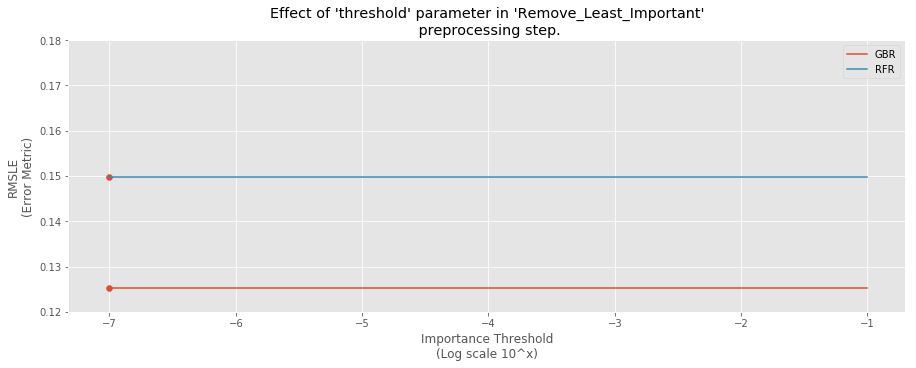

In [13]:
#Plot results
fig , ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(thresh_df.threshold, thresh_df.GBR_score, label='GBR')
ax.plot(thresh_df.threshold, thresh_df.RFR_score, label='RFR')
y_mins = [min(thresh_df.GBR_score), min(thresh_df.RFR_score)]
x_mins = [thresh_df['threshold'].iloc[thresh_df.GBR_score.idxmin],
         thresh_df['threshold'].iloc[thresh_df.RFR_score.idxmin]]
ax.scatter(x_mins, y_mins)
ax.set(ylim=(0.12, 0.18),
       xlabel='Importance Threshold\n(Log scale 10^x)',
       ylabel='RMSLE\n(Error Metric)',
       title="Effect of 'threshold' parameter in 'Remove_Least_Important'\n preprocessing step.",
      )
ax.legend(loc='best')
plt.show()
#Observation
#   Little variation in performance for thresholds < 10^-4. Most likely these are all essentially just removing
#   features with zero importance. A threshold of 10^-5 will be used for the final preprossesing pipe.

### 1c. Final Preprocessing Pipe
Following the preceeding refinements, the preprocessing pipeline is as follows;

In [14]:
preprocess_pipe_final = Pipeline([
    ('Replace_NaNs', Replace_NaNs()), 
    ('Match_Data_Types', Match_Data_Types()),
    ('Remove_No_Correlation', Remove_No_Correlation(no_correlation)), #EDA Finding 2
    ('Remove_Cat', Remove_Cat(remove_cat)), #EDA Finding 8
    ('Convert_to_Cat', Convert_to_Cat(convert_to_cat)), #EDA Finding 3
    ('Log_Feats', Log_Feats(log_feats)), #EDA Finding 5
    ('OverallCond_to_Cat', OverallCond_to_Cat()), #EDA Finding 4
    ('Convert_to_Binary', Convert_to_Binary(convert_to_bin_cat)), #EDA Finding 6
    ('StandardScale_Df', StandardScale_Df()),
    ('Convert_to_Ind', Convert_to_Ind(drop_list = remove_subcats)), #EDA Finding 9
    ('Remove_Least_Important', Remove_Least_Important(threshold=10**-5, random_seed=seed)) #EDA Finding 10
])
X_clean = preprocess_pipe_final.fit_transform(X, y)

## 2. Model Selection
This section assessed the performance of various regression algorithms.   
Each is tested across a range of hyperparameters. An iterative approach to the gridsearch method is used on each algorithm. While this iterative approach will not guarentee to find the globally optimum parameters, it is a reasonable approach. 

In [15]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

### 2a. Algorithm Tests

### Linear Regression

In [16]:
#Linear Regression Model
LR = ElasticNet(random_state=seed)
    
### Grid Search
LR_tuning_params = [{'l1_ratio':np.arange(0.01, 0.04, 0.002),
                     'alpha':np.arange(0.001, 0.011, 0.001)}]

LR_Search = GridSearchCV(
              LR, 
              LR_tuning_params,
              cv=kfold, 
              scoring= 'neg_mean_squared_error',
              verbose = 5,
              n_jobs = 4)

LR_Search.fit(X_clean, y)
LR_Search.best_params_    

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   43.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.4s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:  1.7min finished


{'alpha': 0.003, 'l1_ratio': 0.038}

#### Iteration 1
LR_tuning_params: 'l1_ratio':np.arange(0.1, 1.1, 0.1), 'alpha':np.arange(0.1, 5, 0.1)

Best Parameters : {'alpha': 0.1, 'l1_ratio': 0.1}

#### Iteration 2
LR_tuning_params: 'l1_ratio':np.arange(0.01, 0.11, 0.01), 'alpha':np.arange(0.01, 0.11, 0.01)

Best Parameters : {'alpha': 0.01, 'l1_ratio': 0.02}

#### Iteration 3
LR_tuning_params: 'l1_ratio':np.arange(0.01, 0.04, 0.002), 'alpha':np.arange(0.001, 0.011, 0.001)

Best & Final Parameters : **{'alpha': 0.003, 'l1_ratio': 0.038}**


In [17]:
# Elastic vs Ridge
# The very low parameters in the gridsearch suggest Ridge regression is dominant over Lasso.
# Here it is checked if pure Ridge regression is a better performer.
elastic = ElasticNet(random_state=seed, alpha=0.003, l1_ratio = 0.038)
scores = np.sqrt((-1)*cross_val_score(elastic, X=X_clean, y=y, cv=kfold, scoring='neg_mean_squared_error'))
print('Elastic Net : ', np.mean(scores))
ridge = Ridge(random_state=seed, alpha=5)
scores = np.sqrt((-1)*cross_val_score(ridge, X=X_clean, y=y, cv=kfold, scoring='neg_mean_squared_error'))
print('Ridge : ', np.mean(scores))
# Observation
# Elastic Net with gridsearch parameters out performs Ridge regression.

Elastic Net :  0.1265760842083367
Ridge :  0.12767330576635397


In [18]:
LR_error = np.sqrt((-1)*LR_Search.best_score_)
print('Elastic Net Linear Regression (RMSLE) : ',LR_error)

Elastic Net Linear Regression (RMSLE) :  0.1297587534585978


### Gradient Boosting Regression

In [19]:
#Gradient Boosting Model
GBR = GradientBoostingRegressor(random_state=seed)
     

### Grid Search
GBR_tuning_params = [{'n_estimators':[3000, 4000],
                 'max_depth':[4, 5],
                 'learning_rate':[0.01],
                 'max_features' : [20]
                 }]

GBR_Search = GridSearchCV(
              GBR, 
              GBR_tuning_params,
              cv=kfold, 
              scoring= 'neg_mean_squared_error',
              verbose = 5,
              n_jobs = 4)

GBR_Search.fit(X_clean, y)
print("Best Parameters : ",GBR_Search.best_params_)
print("Best Score : ",np.sqrt((-1)*GBR_Search.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  2.5min finished


Best Parameters :  {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 20, 'n_estimators': 4000}
Best Score :  0.11639376160688393


#### Iteration 1
GBR_tuning_params:
'n_estimators':[10, 50, 100, 500, 1000, 2000],  'max_depth':[3, 6, 12],  'learning_rate':[0.01, 0.05, 0.1],   
'max_features' : [20, 50, 70, 100]
    
Best Parameters : {'learning_rate': 0.01,  'max_depth': 3,  'max_features': 20,  'n_estimators': 2000}
Best Score : 0.11940

#### Iteration 2
GBR_tuning_params:
'n_estimators':[1500, 2000, 3000],  'max_depth':[2, 3, 4],  'learning_rate':[0.005, 0.01, 0.03],   
'max_features' : [10, 20, 30]

Best Parameters :  {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 20, 'n_estimators': 3000}
Best Score :  0.11655

#### Iteration 3
GBR_tuning_params:
'n_estimators':[3000, 4000],  'max_depth':[4, 5],  'learning_rate':[0.01],   
'max_features' : [20]

Final Parameters :  **{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 20, 'n_estimators': 4000}**
Best Score :  0.11639

In [20]:
GBR_error = np.sqrt((-1)*GBR_Search.best_score_)
print('Gradient Boosting Regressor (RMSLE) : ',GBR_error)

Gradient Boosting Regressor (RMSLE) :  0.11639376160688393


### Random Forest Regression

In [21]:
RFR = RandomForestRegressor(random_state=seed)

### Grid Search
RFR_tuning_params = [{'n_estimators':[1200, 1500, 1800],
                 'max_depth':[20],
                 'max_features' : [70]
                 }]

RFR_Search = GridSearchCV(
              RFR, 
              RFR_tuning_params,
              cv=kfold, 
              scoring= 'neg_mean_squared_error',
              verbose = 3,
              n_jobs = 4)

RFR_Search.fit(X_clean, y)
print("Best Parameters : ",RFR_Search.best_params_)
print("Best Score : ",np.sqrt((-1)*RFR_Search.best_score_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  4.9min finished


Best Parameters :  {'max_depth': 20, 'max_features': 70, 'n_estimators': 1200}
Best Score :  0.1358114447270893


#### Iteration 1   
RFR_tuning_params:   
'n_estimators':[10, 50, 100, 500, 1000, 2000],  'max_depth':[3, 6, 12],  'max_features' : [20, 50, 70, 100, 200]   

Best Parameters :  {'max_depth': 12, 'max_features': 70, 'n_estimators': 2000}
Best Score :  0.13626

#### Iteration 2
RFR_tuning_params: 
'n_estimators':[1500, 2000, 2500],  'max_depth':[12, 20, 30],  'max_features' : [60, 70, 80]

Best Parameters :  {'max_depth': 20, 'max_features': 70, 'n_estimators': 1500}
Best Score :  0.13593

#### Iteration 3
RFR_tuning_params: 
'n_estimators':[1200, 1500, 1800],  'max_depth':[20],  'max_features' : [70]

Final Parameters :  **{'max_depth': 20, 'max_features': 70, 'n_estimators': 1200}**
Best Score :  0.13581 

In [22]:
RFR_error = np.sqrt((-1)*RFR_Search.best_score_)
print('Random Forest Regressor (RMSLE) : ',RFR_error)

Random Forest Regressor (RMSLE) :  0.1358114447270893


### AdaBoost Regression

In [23]:
AD = AdaBoostRegressor(random_state=seed)

### Grid Search
AD_tuning_params = [{'n_estimators':[300, 500, 800],
                     'learning_rate' : [0.03, 0.05, 0.08],
                     'loss' : ['linear']
                   }]

AD_Search = GridSearchCV(
              AD, 
              AD_tuning_params,
              cv=kfold, 
              scoring= 'neg_mean_squared_error',
              verbose = 3,
              n_jobs = 4)

AD_Search.fit(X_clean, y)
print("Best Parameters : ",AD_Search.best_params_)
print("Best Score : ",np.sqrt((-1)*AD_Search.best_score_))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  5.3min finished


Best Parameters :  {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 500}
Best Score :  0.17638377911688258


#### Iteration 1   
AD_tuning_params:   
'n_estimators':[100, 500, 1000, 1500, 2000],  'learning_rate' : [0.01, 0.05, 0.1],  'loss' : ['linear', 'square']

Best Parameters :  {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 500}
Best Score :  0.17638 

#### Iteration 2   
AD_tuning_params:   
'n_estimators':[300, 500, 800],  'learning_rate' : [0.03, 0.05, 0.08],  'loss' : ['linear']

Final Parameters :  **{'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 500}**
Best Score :  0.17638

In [24]:
AD_error = np.sqrt((-1)*AD_Search.best_score_)
print('AdaBoost Regressor with decision tree base (RMSLE) : ', AD_error)

AdaBoost Regressor with decision tree base (RMSLE) :  0.17638377911688258


### 2b. Ensemble Methods
Gradient Boosting Regressor appears to be outperforming the other algorithms tested.
Here every combination of these predictors is tested to see if an Ensemble can out performe the Gradient
Boosting model.

In [25]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [26]:
class Ensemble_Model(BaseEstimator):  
    """Ensemble of regression models"""

    def __init__(self, models, weights = None, **Params):
        self.models = models
        self.weights = weights

    def fit(self, X, y=None, **Params):
        for m in self.models:
            m.fit(X,y)
        return self

    def predict(self, X, **Params):
        y_pred_ind = [np.expm1(np.array(m.predict(X))) for m in self.models]
        if type(self.weights) == list:       
            self.weights = np.array(self.weights) / sum(self.weights) # normalise weights
            y_pred = [y_pred_ind[i] * self.weights[i] for i in np.arange(len(self.weights))]
            y_pred = list(np.log1p(sum(y_pred)))
        else:
            y_pred = list(np.log1p(sum(y_pred_ind)/len(self.models)))
            
        return y_pred


In [27]:
#Final model parameters
LR = ElasticNet(random_state=seed, alpha=0.003, l1_ratio = 0.038)
GBR = GradientBoostingRegressor(random_state=seed, learning_rate=0.01, max_depth=4, max_features=20, n_estimators=4000)
RFR = RandomForestRegressor(random_state=seed, max_depth=20, max_features=70, n_estimators=1200)
AD = AdaBoostRegressor(random_state=seed, n_estimators=500, learning_rate=0.05, loss='linear')

In [28]:
# Errors
LR_error = 0.1297587534585978
GBR_error = 0.11639376160688393
RFR_error = 0.1358114447270893
AD_error = 0.17638377911688258

#### Assess Ensemble Combinations
Every combination of models is assessed for performance on the training set. The models are combined as both a straight forward average and a weighted average  based on their respective cross validation scores.

In [29]:
# Initial Lists
weights = [1/LR_error, 1/GBR_error, 1/RFR_error, 1/AD_error]
models = [LR, GBR, RFR, AD]
en_models = []
en_results = []
en_weights = []

In [30]:
# Combinations
inds = list(np.arange(len(models)))
combs =list(itertools.combinations(inds, 1)) +\
        list(itertools.combinations(inds, 2)) +\
        list(itertools.combinations(inds, 3)) +\
        list(itertools.combinations(inds, 4))
# Loop over all combinations
for inc_weight in [False, True]:
    for comb in combs:
        # Ensemble parameters
        model_in = [models[i] for i in comb]
        if inc_weight:
            weight_in = [weights[i] for i in comb]
        else:
            weight_in = None
        # Run CV on ensemble
        print([['LR','GBR', 'RFR', 'AD'][i] for i in comb])
        ensemble = Ensemble_Model(models=model_in, weights=weight_in)
        en_cv_scores = np.sqrt((-1)*cross_val_score(ensemble, X=X_clean, y=y, cv=kfold, scoring='neg_mean_squared_error'))
        en_models.append([['LR','GBR', 'RFR', 'AD'][i] for i in comb])
        en_results.append(np.mean(en_cv_scores))
        en_weights.append(inc_weight)
        
en_results_df = pd.DataFrame({'Model':en_models, 'Weighted':en_weights, 'RMSLE':en_results}).sort_values(by='RMSLE')

['LR']
['GBR']
['RFR']
['AD']
['LR', 'GBR']
['LR', 'RFR']
['LR', 'AD']
['GBR', 'RFR']
['GBR', 'AD']
['RFR', 'AD']
['LR', 'GBR', 'RFR']
['LR', 'GBR', 'AD']
['LR', 'RFR', 'AD']
['GBR', 'RFR', 'AD']
['LR', 'GBR', 'RFR', 'AD']
['LR']
['GBR']
['RFR']
['AD']
['LR', 'GBR']
['LR', 'RFR']
['LR', 'AD']
['GBR', 'RFR']
['GBR', 'AD']
['RFR', 'AD']
['LR', 'GBR', 'RFR']
['LR', 'GBR', 'AD']
['LR', 'RFR', 'AD']
['GBR', 'RFR', 'AD']
['LR', 'GBR', 'RFR', 'AD']


In [31]:
# Results
en_results_df
# Observations
#    Gradient Boosting Model out performs any ensemble.
#    In all cases the weighted ensemble out performs the unweighted version.
#    Worth investigating other wighting strategies.

,Model,RMSLE,Weighted
1,[GBR],0.114704,False
16,[GBR],0.114704,True
19,"[LR, GBR]",0.117480,True
4,"[LR, GBR]",0.117795,False
25,"[LR, GBR, RFR]",0.118600,True
10,"[LR, GBR, RFR]",0.118963,False
22,"[GBR, RFR]",0.120065,True
7,"[GBR, RFR]",0.120823,False
26,"[LR, GBR, AD]",0.122783,True
20,"[LR, RFR]",0.123067,True


#### Weighting strategies
The best performing ensembles are used to assess different weighting strategies.

In [32]:
# Initial Lists
weight_power = []
weight_results = []
model_comb = []

In [33]:
# Assess the best performing ensembles with different weighting strategies.
for j, model_list in enumerate([[LR, GBR], [LR, GBR, RFR], [GBR, RFR], [LR, GBR, AD], [LR, GBR, RFR, AD]]):
    models_used = ['[LR, GBR]', '[LR, GBR, RFR]', '[GBR, RFR]', '[LR, GBR, AD]', '[LR, GBR, RFR, AD]'][j]
    for i in [0.5, 1, 2, 3, 4, 5]:
        print(models_used, " ",i)
        weight_temp = list(np.power(weights, i))[0:len(model_list)]
        ensemble = Ensemble_Model(models=model_list, weights=weight_temp)
        en_cv_scores = np.sqrt((-1)*cross_val_score(ensemble, X=X_clean, y=y, cv=kfold, scoring='neg_mean_squared_error'))
        weight_power.append(i)
        weight_results.append(np.mean(en_cv_scores))
        model_comb.append(models_used)
weight_results_df = pd.DataFrame({'Models  Used': model_comb, 'Weighting Power': weight_power, 'RMSLE': weight_results}).sort_values(by='RMSLE')

[LR, GBR]   0.5
[LR, GBR]   1
[LR, GBR]   2
[LR, GBR]   3
[LR, GBR]   4
[LR, GBR]   5
[LR, GBR, RFR]   0.5
[LR, GBR, RFR]   1
[LR, GBR, RFR]   2
[LR, GBR, RFR]   3
[LR, GBR, RFR]   4
[LR, GBR, RFR]   5
[GBR, RFR]   0.5
[GBR, RFR]   1
[GBR, RFR]   2
[GBR, RFR]   3
[GBR, RFR]   4
[GBR, RFR]   5
[LR, GBR, AD]   0.5
[LR, GBR, AD]   1
[LR, GBR, AD]   2
[LR, GBR, AD]   3
[LR, GBR, AD]   4
[LR, GBR, AD]   5
[LR, GBR, RFR, AD]   0.5
[LR, GBR, RFR, AD]   1
[LR, GBR, RFR, AD]   2
[LR, GBR, RFR, AD]   3
[LR, GBR, RFR, AD]   4
[LR, GBR, RFR, AD]   5


In [34]:
# Results
weight_results_df
# Observation
#    No ensemble weightings out perform the basic Gradient Boosting Regressor.
#    As the power index of the weightings increases the RMSLE tends towards the GBR score.
#    Gradient Boosting Regression is the best performing model, however, only by a small amount.   
#    It could be that the ensmeble methods generalise better to new data therefore both will be carried forward.

,Models Used,RMSLE,Weighting Power
5,"[LR, GBR]",0.116410,5.0
4,"[LR, GBR]",0.116647,4.0
3,"[LR, GBR]",0.116905,3.0
2,"[LR, GBR]",0.117183,2.0
11,"[LR, GBR, RFR]",0.117281,5.0
1,"[LR, GBR]",0.117480,1.0
10,"[LR, GBR, RFR]",0.117587,4.0
0,"[LR, GBR]",0.117636,0.5
9,"[LR, GBR, RFR]",0.117910,3.0
8,"[LR, GBR, RFR]",0.118248,2.0


### Effect  of Randomness within Models
Random Forest and Gradient Boosting regressors are based on an element of randomness.
Here it is checked whether the model performance is improved by combining multiple models with different random seeds.

In [35]:
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [36]:
#Weights
LR_error = 0.1297587534585978
GBR_error = 0.11639376160688393
RFR_error = 0.1358114447270893
AD_error = 0.17638377911688258
# Predictions
en_rand_predictions = []
lr_rand_predictions = []
gbr_rand_predictions = []
rfr_rand_predictions = []
X_1, X_2, y_1, y_2 = train_test_split(X_clean, y, test_size=0.20)
for i in tqdm(np.arange(1, 1001)):
    #Models
    LR = ElasticNet(random_state=seed+i, alpha=0.003, l1_ratio = 0.038)
    LR.fit(X_1,y_1)
    lr_rand_predictions.append(np.array(LR.predict(X_2)))
    GBR = GradientBoostingRegressor(random_state=seed+i, learning_rate=0.01, max_depth=4, max_features=20, n_estimators=4000)
    GBR.fit(X_1,y_1)
    gbr_rand_predictions.append(np.array(GBR.predict(X_2)))
    RFR = RandomForestRegressor(random_state=seed+i, max_depth=20, max_features=70, n_estimators=1200)
    RFR.fit(X_1,y_1)
    rfr_rand_predictions.append(np.array(RFR.predict(X_2)))
    #Ensemble
    ensemble = Ensemble_Model(models=[LR, GBR, RFR], weights=[1/LR_error, 1/GBR_error, 1/RFR_error])
    ensemble.fit(X_1, y_1)
    en_rand_predictions.append(np.array(ensemble.predict(X_2)))

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [10:59:53<00:00, 39.59s/it]


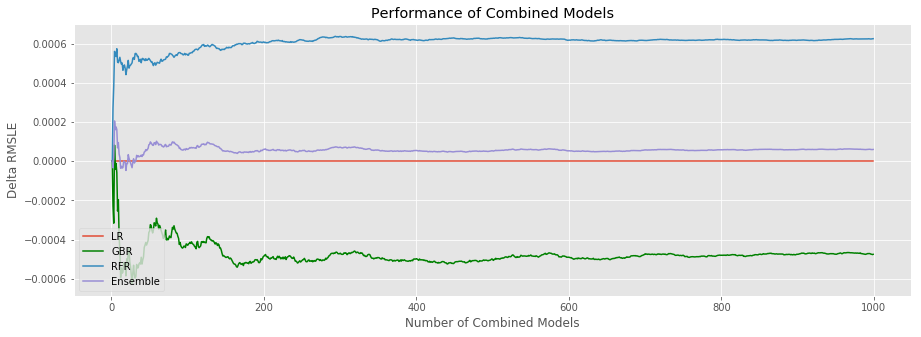

In [47]:
# Lists
lr_rand_RMSLE = []
gbr_rand_RMSLE = []
rfr_rand_RMSLE = []
en_rand_RMSLE = []
# Baseline Errors
lr_error = np.sqrt(mean_squared_error(y_2, lr_rand_predictions[0]))
gbr_error = np.sqrt(mean_squared_error(y_2, gbr_rand_predictions[0]))
rfr_error = np.sqrt(mean_squared_error(y_2, rfr_rand_predictions[0]))
en_error = np.sqrt(mean_squared_error(y_2, en_rand_predictions[0]))
# 
for i in np.arange(1,len(en_rand_predictions)):
    lr_preds = sum(lr_rand_predictions[:i])/i
    lr_rand_RMSLE.append(np.sqrt(mean_squared_error(y_2, lr_preds))-lr_error)
    gbr_preds = sum(gbr_rand_predictions[:i])/i
    gbr_rand_RMSLE.append(np.sqrt(mean_squared_error(y_2, gbr_preds))-gbr_error)
    rfr_preds = sum(rfr_rand_predictions[:i])/i
    rfr_rand_RMSLE.append(np.sqrt(mean_squared_error(y_2, rfr_preds))-rfr_error)
    combined_preds = sum(en_rand_predictions[:i])/i
    en_rand_RMSLE.append(np.sqrt(mean_squared_error(y_2, combined_preds))-en_error)
#Plots
# Score improvement with 
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(np.arange(1,len(lr_rand_RMSLE)+1), lr_rand_RMSLE, label='LR');
ax.plot(np.arange(1,len(gbr_rand_RMSLE)+1), gbr_rand_RMSLE, label='GBR', color='g');
ax.plot(np.arange(1,len(rfr_rand_RMSLE)+1), rfr_rand_RMSLE, label='RFR');
ax.plot(np.arange(1,len(en_rand_RMSLE)+1), en_rand_RMSLE, label='Ensemble');
ax.set(title='Performance of Combined Models', xlabel='Number of Combined Models', ylabel='Delta RMSLE');
ax.legend(loc='best')

In [38]:
# Observation
#    The final sumbmission will use 50 different random seeds to remove the effect of randomness

## 3. Competition Submission
### 3a. Gradient Boosting Regression Submission

In [39]:
# Import Data
comp = pd.read_csv('datasets/test.csv')
X_comp = comp.drop(['Id'], axis=1)
ID_comp = comp['Id']

In [40]:
# Preprocess Competition Data
#X_clean = preprocess_pipe_final.fit_transform(X, y)
X_comp_clean = preprocess_pipe_final.transform(X_comp)

In [41]:
# GBR Model
GBR_model_list = [GradientBoostingRegressor(random_state=seed+i, learning_rate=0.03, max_depth=4, max_features=25, n_estimators=1700)
                   for i in np.arange(50)]
ensemble_comp = Ensemble_Model(GBR_model_list)
ensemble_comp.fit(X_clean, y)
y_comp = np.expm1(ensemble_comp.predict(X_comp_clean))

In [42]:
# Required Submission Format
comp_sumbmission = pd.DataFrame({'ID' : ID_comp,
                                'SalePrice' : y_comp})
comp_sumbmission.to_csv('Submission_001.csv', index = False)

#### Competition Score - 0.12689
   
      
      



### 3b. Ensemble Submission (GBR, RFR, LR)

In [43]:
# Ensemble Model
LR = ElasticNet(alpha=0.003, l1_ratio = 0.038)
GBR = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, max_features=20, n_estimators=4000)
RFR = RandomForestRegressor(max_depth=20, max_features=70, n_estimators=1200)

weights = [1/LR_error]*50 + [1/GBR_error]*50 + [1/RFR_error]*50
models = [LR]*50 + [GBR]*50 + [RFR]*50

ensemble = Ensemble_Model(models, weights)

ensemble.fit(X_clean, y)
y_comp = np.expm1(ensemble.predict(X_comp_clean))

In [44]:
# Required Submission Format
comp_sumbmission = pd.DataFrame({'ID' : ID_comp,
                                'SalePrice' : y_comp})
comp_sumbmission.to_csv('Submission_002.csv', index = False)

#### Competition Score - 0.12412

In [45]:
# Rounded to nearest $500
y_comp_round = (np.array(y_comp)//500)*500
comp_sumbmission = pd.DataFrame({'ID' : ID_comp,
                                'SalePrice' : y_comp_round})
comp_sumbmission.to_csv('Submission_003.csv', index = False)

#### Competition Score - 0.12422

   
#### Export Data for Experiments

In [46]:
X_clean.to_csv('datasets/X_clean.csv', index=False)
X_comp_clean.to_csv('datasets/X_comp_clean.csv', index=False)